In [1]:
import os
import operator
import numpy as np
from typing import List
from gensim.models import KeyedVectors, Word2Vec
from gensim.test.utils import datapath
import matplotlib.pyplot as plt

In [2]:
def load_dataset(path) -> List[tuple[List[str], str]]:
    result = []
    for file in os.listdir(path):
        if file.endswith('.txt'):
            with open(path + '/' + file) as f:
                cluster_reading = True
                cluster = []
                outliers = []
                for line in f:
                    line = line.rstrip()
                    if len(line) > 0:
                        if not line.startswith('#'):
                            if cluster_reading:
                                cluster.append(line)
                            else:
                                outliers.append(line)
                    else:
                        cluster_reading = False
                for outlier in outliers:
                    result.append((cluster, outlier))
    return result

In [3]:
def compute_accuracy(dataset, sim_fun):
    similarities = {}
    correct_guesses = 0
    total_guesses = 0
    for sample in dataset:
        cluster, outlier = sample
        items = cluster + [outlier]
        compactness = {}
        for item1 in items:
            compactness[item1] = 0.0
            for item2 in items:
                if item1 != item2:
                    compactness[item1] += sim_fun(item1, item2)
        least_compact = sorted(compactness.items(), key=operator.itemgetter(1))[0][0]
        if least_compact == outlier:
            correct_guesses += 1
        else:
            print(f"Failed {cluster} / {outlier}")
        total_guesses += 1
    return correct_guesses / total_guesses

In [4]:
wv = KeyedVectors.load_word2vec_format('word2vec-cc100-cbow-d100-w3-min10.vectors', binary=False)

In [5]:
wv.similarity('шчанюк', 'сабака')

0.8072199

In [6]:
eval_dataset = load_dataset('evaluation/outlier-detection')

In [7]:
compute_accuracy(eval_dataset, lambda w1, w2: wv.similarity(w1, w2))

Failed ['вуліца', 'дом', 'парк', 'плошча', 'праспект', 'сквер', 'завулак', 'бульвар'] / вёска
Failed ['галава', 'рука', 'нага', 'тулава', 'шыя', 'палец', 'спіна', 'плячо'] / шапка
Failed ['яблык', 'банан', 'апельсін', 'персік', 'груша', 'сліва', 'мандарын', 'ківі'] / морква
Failed ['яблык', 'банан', 'апельсін', 'персік', 'груша', 'сліва', 'мандарын', 'ківі'] / зеляніна
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / рака
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / кіт
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / плаўнік
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / дно
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / васьміног
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / човен
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / збр

0.8333333333333334

In [8]:
model = Word2Vec.load("word2vec-cc100-cbow-d100-w3-min10.model")

Let's check whether we have correlation between frequency of a word and its average similarity to another word.

In [9]:
vocab_size = len(model.wv.index_to_key)
pairs = [(np.random.randint(vocab_size), np.random.randint(vocab_size)) for _ in range(1000)]
similarities = [model.wv.similarity(model.wv.index_to_key[p[0]], model.wv.index_to_key[p[1]]) for p in pairs]

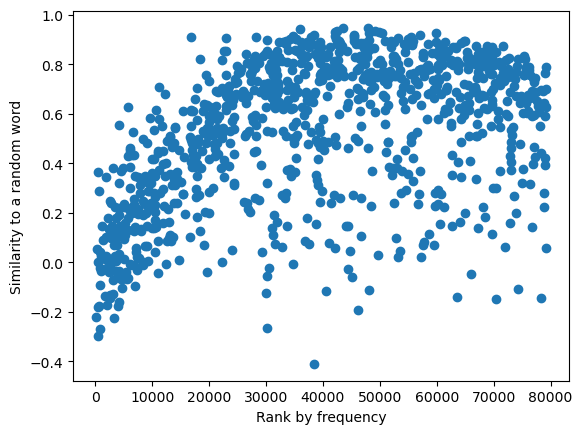

In [10]:
plt.scatter([p[0] for p in pairs], similarities)
plt.xlabel('Rank by frequency')
plt.ylabel('Similarity to a random word')
plt.show()

Checking most similar words for a rare word:

In [11]:
model.wv.get_vecattr("пітон","count")

289

In [12]:
closest_words = []
for word, similarity in model.wv.most_similar('пітон', topn=5000):
    closest_words.append((word, similarity, model.wv.get_vecattr(word,"count"))) 

for word, similarity, count in closest_words[:20]:
    print(word.ljust(10) + "\t" + "%.2f" % similarity, count)

бегемот   	0.96 259
хвастаты  	0.96 182
вожыкаў   	0.96 259
гіена     	0.96 237
янот      	0.95 352
кобра     	0.95 189
таракан   	0.95 399
андатра   	0.95 121
качаня    	0.95 303
вушасты   	0.95 195
шэршань   	0.95 329
хамяк     	0.95 358
антылопа  	0.94 266
мошка     	0.94 220
палёўка   	0.94 122
тхор      	0.94 260
аднарог   	0.94 357
вавёрачка 	0.94 179
хорт      	0.94 181
тэр'ер    	0.94 165


It seems rare words are very close to other rare words. Let's find whether some frequent words are close too.

In [13]:
frequent_words = [i for i in range(len(closest_words)) if closest_words[i][2] > 800]
frequent_words

[1634, 1932, 3709, 3913, 4088, 4162]

In [14]:
for ind in frequent_words:
    word, similarity, count = closest_words[ind]
    print(word.ljust(10) + "\t" + "%.2f" % similarity, count)

вуж       	0.89 814
звярок    	0.89 944
папугай   	0.88 1002
слімак    	0.88 823
рой       	0.88 831
яшчарка   	0.88 803


Doesn't make sense even for more frequent words. Let's check the structure of vectors

In [15]:
model.wv.get_vector('пітон')

array([-1.41770661e-01,  1.26781732e-01,  7.23062828e-02, -5.75582869e-02,
       -3.21447067e-02, -2.19046980e-01,  5.10353316e-03,  3.31474632e-01,
       -9.69028100e-02, -3.41708213e-02, -1.61939964e-01, -1.36964113e-01,
       -5.84080108e-02, -6.32776394e-02,  5.04812896e-02, -1.12654962e-01,
       -1.05013698e-03, -2.68294185e-01,  1.00394174e-01, -1.43432006e-01,
        2.07447708e-02,  7.73284361e-02,  5.92699982e-02, -9.09905210e-02,
       -5.64790443e-02,  1.74639467e-02, -2.79137343e-02, -1.20589398e-01,
       -1.93175361e-01, -2.35905289e-03,  1.41731560e-01,  1.06295392e-01,
        2.85691172e-02, -2.04793036e-01, -4.47116382e-02,  1.65863067e-01,
        8.14851522e-02, -1.66297019e-01, -9.11497697e-02, -1.54322565e-01,
        1.97603516e-02, -1.50850520e-01, -1.09569371e-01,  2.57620066e-02,
        1.17170997e-01, -9.26148221e-02, -1.31724596e-01, -4.96051386e-02,
        1.49485175e-04,  9.33466479e-02,  5.36112711e-02, -1.53736204e-01,
       -8.39198008e-03, -

In [16]:
np.mean(np.abs(model.wv.get_vector('пітон')))

0.10176192

In [17]:
np.mean(np.abs(model.wv.get_vector('беларусь')))

2.7613592

In [18]:
coord_abs_values = [np.mean(np.abs(model.wv.get_vector(word))) for word in model.wv.index_to_key]

Text(0, 0.5, 'Mean absolute coordinate value of embedding')

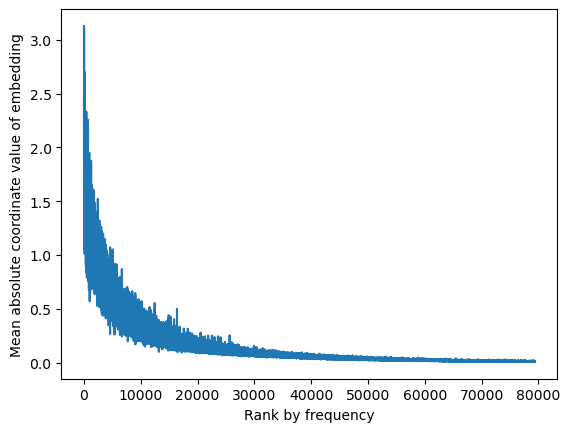

In [19]:
plt.plot(coord_abs_values)
plt.xlabel('Rank by frequency')
plt.ylabel('Mean absolute coordinate value of embedding')

Seems rare words have low absolute values for coordinates. This however doesn't explain the clustering of them from cosine similarity perspective.